# Optimal/Horne extraction exploration

At the time this notebook was written, Horne extraction did not exist in `specreduce`. It adapts a preliminary workflow from a JDAT Notebook and the original paper introducing the method.

There are notes *[in brackets]* on how each step is handled in the proposed `HorneExtract`/`OptimalExtract` classes to make it easier to see what the class does and what the user must do themselves.

### Steps in the [JDAT Notebook guide](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral%20Extraction-static.html) on optimal extraction:

_(See that notebook rendered as a webpage [here](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral%20Extraction-static.html).)_

1. Define extraction region [__user's responsibility__ to provide an appropriate image]
2. Pick a slice [**should not be necessary?** can use the whole image as the aperture with good results]
3. Define extraction kernel
    - Select PSF template [**assumed to be Gaussian** for now. support for Moffat, others?]
    - Choose a polynomial for background fitting [**user provides** as an argument]
4. Fit extraction kernel to initial slice [**all columns are coadded** to perform the fit]
5. Fit geometric distortion [not currently done]
    - Determine cross-dispersion bins for trace fitting 
    - Fit a kernel to each bin to find trace center [**user provides** this as a `specreduce.tracing.Trace` object]
    - Polynomial fit of trace centers
6. Combine composite model with 2D image to create output 1D spectrum
    - Create variance image [**user provides** this as an argument]
    - Generate 1D spectrum
7. Compare with reference 1D spectrum

### Steps in the original [Horne (1986)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H%2F/abstract) paper:

1. Bias subtraction [assumed to be done in earlier block]
2. Initial variance estimate [**user provides** this as an argument]
3. Fit sky background [assumed to be done in earlier block]
    - "We therefore generally perform a least-squares polynomial fit to the sky data at each wavelength. Individual sky pixels are given weights inversely proportional to their variances as estimated in Step 2" *[overlaps with notebook guide's 3b]*
4. Extract standard spectrum and its variance
    - Subtract the sky background found in Step 3 from the image. [sky background calculation is planned as a separate, earlier step of the `specreduce` workflow]
5. Construct spatial profile
6. Revise variance estimates [not currently done]
7. Mask cosmic ray hits [not currently done]
8. Extract optimal spectrum and its variance [currently **only extract the spectum**, not a variance]
9. Iterate Steps 5-8

I understand the first four steps as the standard procedure and the last five as add-ons that help squeeze out extra signal-to-noise.

# Procedure

I will follow steps from the notebook more closely with an eye on adding steps from the paper as we improve functionality. We are limiting to 2D spectra at the moment with an eye on supporting 3D spectra in the future.

## I. Prelude

### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.visualization import simple_norm
from astropy import units as u
from matplotlib.patches import Rectangle
from pathlib import Path
from specreduce import SpecreduceOperation
from specreduce.tracing import FlatTrace

In [2]:
mpl.rcParams.update({'axes.titlesize': 18, 'axes.labelsize': 12,
                     'legend.fontsize': 12,  'axes.grid': False,
                     'grid.alpha': .5, 'grid.color': 'k',
                     'axes.edgecolor': 'k'})

### Get spectral files
Download the files with names containing `126153` and `127036` from this [Box folder](https://stsci.app.box.com/s/io2gk1r7di0ryhtnxuh4mevvyaj5oqmn). Then, replace the `...` in the following cell with their location on your machine.

In [3]:
download_dir = Path('...')

In [4]:
# 2d spectra
file_2d1 = download_dir / Path('legac_M1_v3.11_spec2d_126153.fits')
file_2d2 = download_dir / Path('legac_M1_v3.11_spec2d_127036.fits')

vlt_img1 = fits.getdata(file_2d1)
vlt_img2 = fits.getdata(file_2d2)

vlt_img1_head = fits.getheader(file_2d1)
vlt_img2_head = fits.getheader(file_2d2)

In [5]:
# 2d weights
file_2d_weight1 = download_dir / Path('legac_M1_v3.11_wht2d_126153.fits')
file_2d_weight2 = download_dir / Path('legac_M1_v3.11_wht2d_127036.fits')

vlt_weight1 = fits.getdata(file_2d_weight1)
vlt_weight2 = fits.getdata(file_2d_weight2)

vlt_weight1_head = fits.getheader(file_2d_weight1)
vlt_weight2_head = fits.getheader(file_2d_weight2)

In [6]:
# 1d references
file_1d1 = download_dir / Path('legac_M1_v3.11_spec1d_126153.fits')
file_1d2 = download_dir / Path('legac_M1_v3.11_spec1d_127036.fits')

vlt_ref1 = fits.getdata(file_1d1)
vlt_ref2 = fits.getdata(file_1d2)

vlt_ref1_head = fits.getheader(file_1d1)
vlt_ref2_head = fits.getheader(file_1d2)

In [7]:
vlt_img1_head[:10]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 6166 / length of data axis 1                          
NAXIS2  =                   81 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-26T12:24:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  

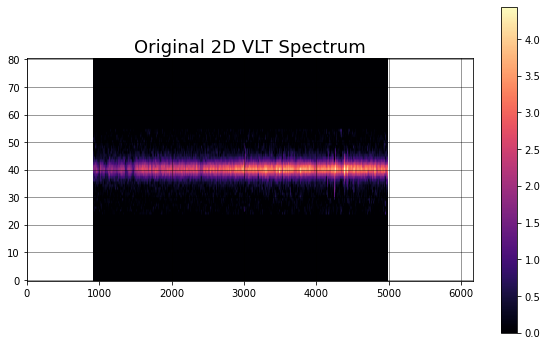

In [8]:
aspect_ratio = vlt_img1.shape[1] / (2 * vlt_img1.shape[0])

fig1, ax1 = plt.subplots(figsize=(10,6))
plot1 = ax1.imshow(vlt_img1,
                   vmin=0, vmax=np.nanmax(vlt_img1) / 2,
                   aspect=aspect_ratio, cmap=mpl.cm.magma, origin='lower')
fig1.colorbar(plot1)
ax1.set_title('Original 2D VLT Spectrum')
ax1.grid()

### Select extraction region
The 2D image has several NaN values, so I begin by slicing it down to its  finite region.

In [9]:
# borders of finite region
xx1 = np.argmin(np.isnan(vlt_img1[0]))
xx2 = vlt_img1.shape[-1] - np.argmin(np.isnan(vlt_img1[0][::-1]))
yy1 = np.flatnonzero(vlt_img1[:,xx1])[0]
yy2 = np.flatnonzero(vlt_img1[:,xx1])[-1]

extraction_region = vlt_img1[yy1:yy2, xx1:xx2]
weight_region = vlt_weight1[yy1:yy2, xx1:xx2]
print((xx1, xx2), (yy1, yy2))

(893, 4992) (24, 54)


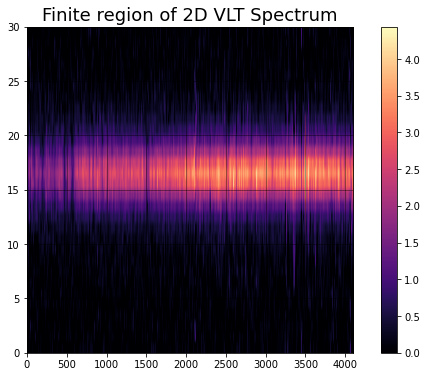

In [10]:
aspect_ratio2 = extraction_region.shape[1] / (1 * extraction_region.shape[0])
fig2, ax2 = plt.subplots(figsize=(10,6))
plot2 = ax2.imshow(extraction_region, aspect=aspect_ratio2,
                   vmin=0, vmax=extraction_region.max()/2,
                   cmap=mpl.cm.magma, origin='lower',
                   extent=(0, extraction_region.shape[-1],
                           0, extraction_region.shape[0]))
fig2.colorbar(plot2)
ax2.set_title('Finite region of 2D VLT Spectrum')
ax2.grid()

### Create variance image

Users must provide their own masked variance image since the equation to calculate one can vary from instrument to instrument. This VLT image's weights can be converted into variances through the equation $V \sim \frac{1}{W}$.

In [11]:
# highlight pixels with positive, finite flux and non-zero weight
good_pix = ((extraction_region > 0) * np.isfinite(extraction_region)
            * (weight_region != 0))
weights_masked = np.ma.array(weight_region, mask=~good_pix)

In [12]:
# create variance image using masked weights
vlt_var1 = np.ma.divide(1, weights_masked)

### Calculate a trace of the selected region

Generate an example trace object using `specreduce`'s `FlatTrace` class, which places the trace at a constant location in the cross-dispersion direction throughout the image.

In [13]:
vlt_trace1 = FlatTrace(extraction_region, 16.5)

Alternatively, code from the [kosmos](https://github.com/jradavenport/kosmos) repository allows for calculation of a trace from the image itself. (This will soon be possible in `specreduce`, too.) To go this route, select the cell below and press "Y" to turn it into a code cell. Then, enter `kosmos`' location on your computer as `kosmos_path`.

Superimpose your trace onto the image to ensure it follows a reasonable path.

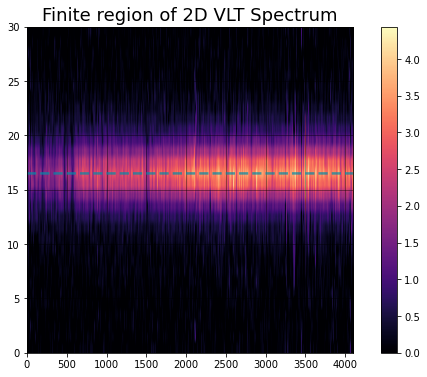

In [14]:
fig3, ax3 = plt.subplots(figsize=(10,6))
plot3 = ax3.imshow(extraction_region, aspect=aspect_ratio2,
                   vmin=0, vmax=extraction_region.max()/2,
                   cmap=mpl.cm.magma, origin='lower',
                   extent=(0, extraction_region.shape[-1],
                           0, extraction_region.shape[0]))
fig3.colorbar(plot3)
ax3.set_title('Finite region of 2D VLT Spectrum')
ax3.grid()

# add the trace
ax3.plot(vlt_trace1.trace, '--', color='#008ca8', lw=2.5, alpha=.7, label='trace')

## II. Extraction
Once the variance image and trace are settled, we have everything needed to begin the extraction. I've created a template `HorneExtract` and `OptimalExtract` template classes with superficially similar structures as `specreduce.extract.BoxcarExtract`. The two classes are aliases of one another and perform the same tasks.

In [15]:
class OptimalExtract(SpecreduceOperation):
    """
    Perform a Horne extraction (a.k.a. optimal) on a region in a
    two-dimensional spectrum.
    """

    def __call__(self, image, variance, trace_object,
                 disp_axis=1, crossdisp_axis=0,
                 bkgrd_prof=models.Polynomial1D(2)):
        """
        Run the Horne calculation on a region of an image and extract a
        1D spectrum.

        Parameters
        ----------

        image : `~astropy.nddata.CCDData` or array-like, required
            The input 2D spectrum from which to extract a source.

        variance : `~astropy.nddata.CCDData` or array-like, required
            The associated variances for each pixel in the image.
            Should have the same dimensions as `image`.

        trace_object : `~specreduce.tracing.Trace`, required
            The associated 1D trace object created for the 2D image.

        disp_axis : int, optional
            The index of the image's dispersion axis. [default: 1]

        crossdisp_axis : int, optional
            The index of the image's cross-dispersion axis. [default: 0]

        bkgrd_prof : `~astropy.modeling.Model`
            A model for the image's background flux.
            [default: models.Polynomial1D(2)]

        Returns
        -------
        spec_1d : `~specutils.Spectrum1D`
            The final, Horne extracted 1D spectrum.
        """
        # nb3a: co-add signal in each column
        ncols = image.shape[crossdisp_axis]
        xd_pixels = np.arange(ncols) # y plot dir / x spec dir
        coadd = image.sum(axis=disp_axis) / ncols

        # nb3a: fit source profile, using Gaussian model as a template
        gauss_prof = models.Gaussian1D(amplitude=coadd.max(),
                                       mean=coadd.argmax(), stddev=2)

        # nb4: Fit extraction kernel to column with combined gaussian/bkgrd model
        ext_prof = gauss_prof + bkgrd_prof
        fitter = fitting.LevMarLSQFitter()
        fit_ext_kernel = fitter(ext_prof, xd_pixels, coadd)

        # nb6: generate 1D spectrum, column by column
        spec_1d = np.zeros(image.shape[disp_axis])
        for col_pix in range(image.shape[disp_axis]):
            # set gaussian model's mean as column's corresponding trace value
            fit_ext_kernel.mean_0 = trace_object.trace[col_pix]
            # kernel_col.stddev_0 = self.fwhm_fit(x)
            # NOTE: support for variable FWHMs forthcoming

            # fit compound model to column
            kernel_vals = fit_ext_kernel(xd_pixels)
            # NOTE: support user-provided kernels? would require different handling
            # NOTE: allow smoothing in x direction via boxcar/x axis collapse/etc?

            # fetch matching columns from original and variance images
            image_col = image[:, col_pix]
            variance_col = variance[:, col_pix]

            # calculate kernel normalization
            g_x = np.ma.sum(kernel_vals**2 / variance_col)
            if np.ma.is_masked(g_x):
                continue

            # sum by column weights
            weighted_col = np.ma.divide(image_col * kernel_vals, variance_col)
            result = np.ma.sum(weighted_col) / g_x

            # multiply kernel normalization into the extracted signal
            result *= (fit_ext_kernel.amplitude_0
                       * fit_ext_kernel.stddev_0 * np.sqrt(2*np.pi))
            spec_1d[col_pix] = result

        return spec_1d


class HorneExtract(OptimalExtract):
    """
    Perform a Horne extraction (a.k.a. optimal) on a region in a
    two-dimensional spectrum.
    """
    pass

In [16]:
ext = OptimalExtract()
result1d = ext(extraction_region, vlt_var1, vlt_trace1)

## III. Results
Calculate wavelengths from the header and compare the extracted 1D spectrum to the reference from VLT's pipeline.

In [17]:
# account for strange format of header keys/values
wv0 = float(vlt_img1_head['HIERARCH ESO PRO REC1 PARAM4 VALUE'])
wv1 = float(vlt_img1_head['HIERARCH ESO PRO REC1 PARAM5 VALUE'])
wavelengths = np.linspace(wv0, wv1, len(result1d))

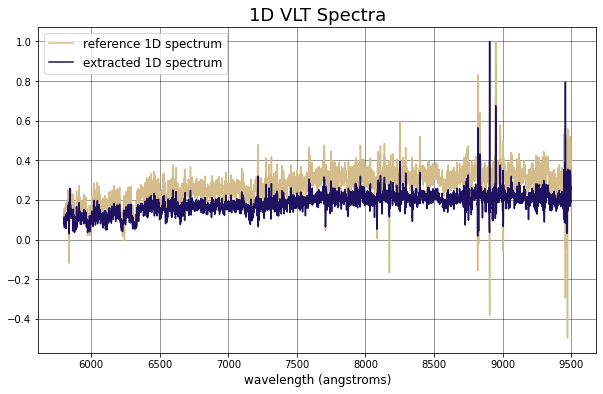

In [18]:
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(wavelengths, vlt_ref1[xx1:xx2] / vlt_ref1[xx1:xx2].max(),
         c='#d4bd8a', label='reference 1D spectrum')
ax4.plot(wavelengths, result1d / result1d.max(),
         c='#1d1160', label='extracted 1D spectrum')
ax4.set_xlabel('wavelength (angstroms)')
ax4.set_title('1D VLT Spectra')#, normalized by max')
ax4.grid()
ax4.legend()

### Remove weight from bad pixels

A couple of large emission "features" are caused by columns with intensity and weights concentrated at the edges, away from the source. Discarding these columns by assigning them zero weight gives a better match to the reference 1D spectrum.

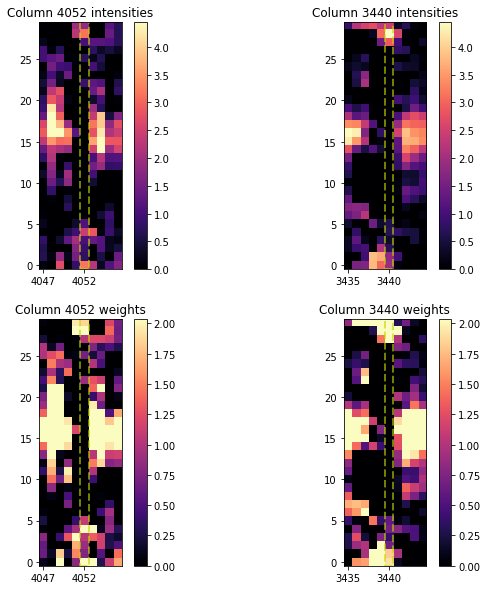

In [19]:
bad_pixels = np.argsort(result1d)[-2:]
buffer = 5

fig5, axs5 = plt.subplots(2, len(bad_pixels), figsize=(10, 10))

for i, arr in enumerate(np.rollaxis(axs5.T, 0)):
# for i, arr in enumerate(axs5, 0):
    # print(arr)
    ax0, ax1 = arr#.T
    region0 = bad_pixels[i] - buffer
    region1 = bad_pixels[i] + buffer
    
    pl0 = ax0.imshow(extraction_region[:, region0:region1],
                     cmap=plt.cm.magma, vmin=0, vmax=extraction_region.max() / 2,
                     origin='lower')
    fig5.colorbar(pl0, ax=ax0)
    ax0.set_xticks([0, buffer], [region0, bad_pixels[i]])
    ax0.set_title(f"Column {bad_pixels[i]} intensities", fontsize=12)
    
    pl1 = ax1.imshow(extraction_region[:, region0:region1],
                     cmap=plt.cm.magma, vmin=0, vmax=weight_region.max() / 2,
                     origin='lower')
    fig5.colorbar(pl1, ax=ax1)
    ax1.set_xticks([0, buffer], [region0, bad_pixels[i]])
    ax1.set_title(f"Column {bad_pixels[i]} weights", fontsize=12)
    
    # if i == 0:
    #     ax0.set_xlabel('pixel')
    #     ax1.set_xlabel('pixel')
    
for arr in axs5:
    for subplt in arr:
        rect5 = Rectangle((buffer - .5, 0 - .5), 1, extraction_region.shape[0],
                  lw=2, edgecolor='#c4d600', alpha=.6, facecolor='none', linestyle='--')
        subplt.add_patch(rect5)

We calculate the extraction with `HorneExtract` this time to show that it also works.

In [20]:
# assign zero weight to "bad" pixels
wei0 = weight_region.copy()
wei0[:, bad_pixels] = 0

# re-try extraction with new weights
ext0 = HorneExtract()
r1d = ext0(extraction_region, wei0, vlt_trace1)

/var/folders/ls/7lh0_8jn0ndbm6g7plbzw8n400028t/T/ipykernel_86235/626082172.py:74: RuntimeWarning: divide by zero encountered in true_divide
  g_x = np.ma.sum(kernel_vals**2 / variance_col)
/var/folders/ls/7lh0_8jn0ndbm6g7plbzw8n400028t/T/ipykernel_86235/626082172.py:85: UserWarning: Warning: converting a masked element to nan.
  spec_1d[col_pix] = result


Compare the 1D spectra, both in raw form and normalized by their maximum values.

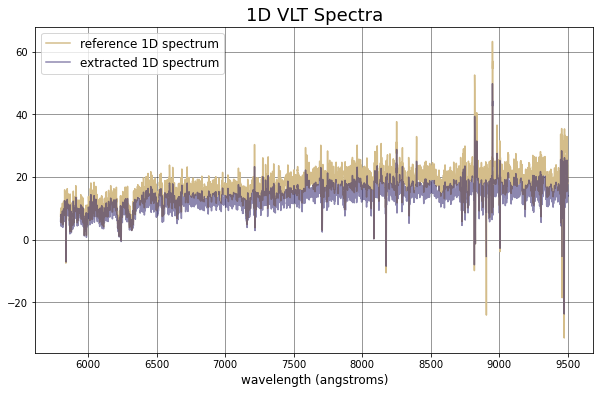

In [21]:
fig6, ax6 = plt.subplots(figsize=(10, 6))
ax6.plot(wavelengths, vlt_ref1[xx1:xx2], #alpha=.5,
         c='#d4bd8a', label='reference 1D spectrum')
ax6.plot(wavelengths, r1d, alpha=.5,
         c='#1d1160', label='extracted 1D spectrum')
ax6.set_xlabel('wavelength (angstroms)')
ax6.set_title('1D VLT Spectra')
ax6.grid()
ax6.legend()

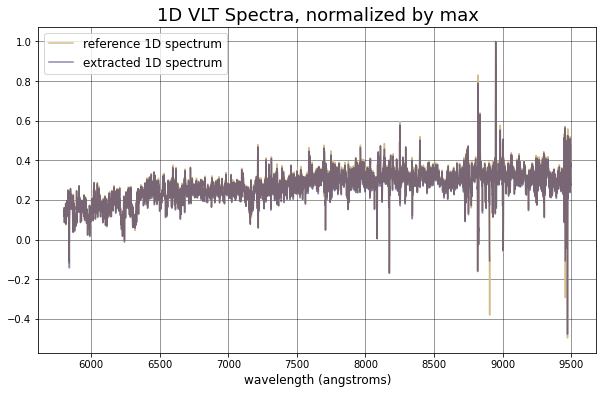

In [22]:
fig6, ax6 = plt.subplots(figsize=(10, 6))
ax6.plot(wavelengths, vlt_ref1[xx1:xx2] / vlt_ref1[xx1:xx2].max(), #alpha=.5,
         c='#d4bd8a', label='reference 1D spectrum')
ax6.plot(wavelengths, r1d / np.nanmax(r1d), alpha=.5,
         c='#1d1160', label='extracted 1D spectrum')
ax6.set_xlabel('wavelength (angstroms)')
ax6.set_title('1D VLT Spectra, normalized by max')
ax6.grid()
ax6.legend()

## About this notebook

**Author:** O. Justin Otor, Indigo/JDAT
<br />
**Updated:** 2022-02

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 